In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

class DiscreteSignal:
    color_cycle = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
    def __init__(self, INF):
        self.INF = INF
        self.values = np.zeros(2 * INF + 1)
    def show(self):
        print(self.values)
    def set_value_at_time(self, time, value):
       self.values[time + self.INF] = value    
    
    def get_value_at_time(self, time):
       return self.values[time + self.INF] 
    def shift_signal(self, shift):
        if abs(shift) > self.INF*2+1:
            self.values = np.zeros(2*self.INF+1)
            return
        if shift > 0:
            self.values = np.concatenate((np.zeros(shift), self.values[0:2*self.INF+1-shift]))
        elif shift < 0:
            self.values = np.concatenate((self.values[-shift:], np.zeros(-shift)))
    
    def add(self,other):
        signal2=DiscreteSignal(self.INF)
        signal2.values=self.values+other.values
        return signal2
    def multiply(self,other):
        signal2=DiscreteSignal(self.INF)
        signal2.values=self.values*other.values
        return signal2  
    def multiply_const_factor(self, scaler):
        signal2=DiscreteSignal(self.INF)
        signal2.values=self.values*scaler
        return signal2
    def plot(self, label='Signal'):
        time_points = np.arange(-self.INF, self.INF + 1, 1)
        color = next(DiscreteSignal.color_cycle)
        plt.stem(time_points, self.values, basefmt=" ", label=label, linefmt=color, markerfmt=color+'o')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        # plt.show()
        
INF=5
signal=DiscreteSignal(INF)
signal_=DiscreteSignal(INF)

class ContinuousSignal:
    def __init__(self,func):
        self.func=func
    def add(self, other):
        # Creating a new ContinuousSignal with a combined function
        signal2 = ContinuousSignal(lambda x: self.func(x) + other.func(x))
        return signal2
    def shift_signal(self, shift):
        # Creating a new ContinuousSignal with a shifted function
        signal2 = ContinuousSignal(lambda x: self.func(x - shift))
        return signal2
    def multiply(self, other):
        # Creating a new ContinuousSignal with a multiplied function
        signal2 = ContinuousSignal(lambda x: self.func(x) * other.func(x))
        return signal2

    def multiply_const_factor(self, scaler):
        # Creating a new ContinuousSignal with a scaled function
        signal2 = ContinuousSignal(lambda x: self.func(x) * scaler)
        return signal2
    def plot(self, start, end, label):
        x = np.linspace(start, end, 1000)
        y = self.func(x)
        
        # Plot on the same figure with a label
        plt.plot(x, y, label=label)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.grid(True)

    @staticmethod
    def show():
        # Call the static method to show all the plots with a legend
        plt.legend()
        plt.show()
        
# def myfunc(x):
#     return 5*np.sin(x)
# def youfunk(x):
#     return x*x;

# contSig=ContinuousSignal(myfunc)
# contSig2=ContinuousSignal(youfunk)
# contSifted=contSig.shift_signal(1)
# contSifted2=contSig.shift_signal(-2)
# contSigAdd=contSig.add(contSig2)
# contSig.plot(-10,10,"contsig")    
# contSifted.plot(-10,10,"contsigshifted")
# contSifted2.plot(-10,10,"contsigshifted2")
# ContinuousSignal.show()

<Figure size 640x480 with 0 Axes>

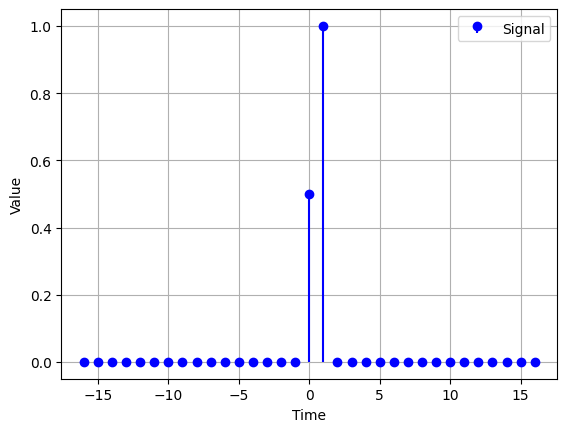

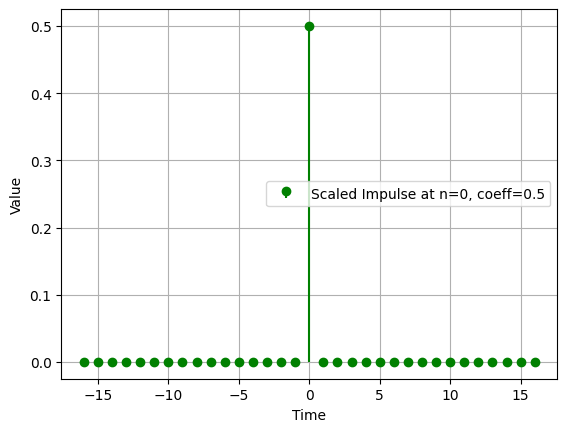

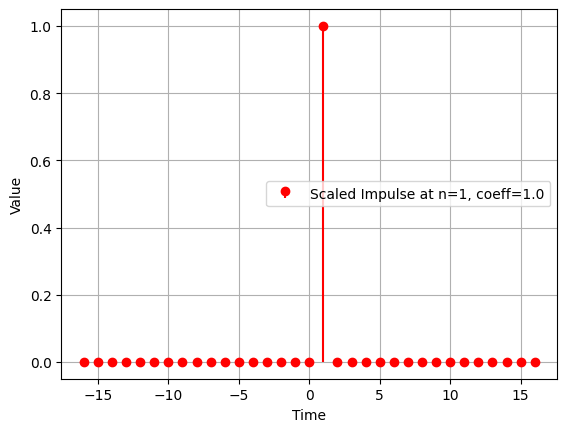

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
class LTI_Discrete:
    def __init__(self, impulse_response):
        self.impulse_response = impulse_response
    
    def linear_combination_of_impulses(self,input_signal):
        decomposed=[]
        for i in range(-self.impulse_response.INF,self.impulse_response.INF+1):
            coefficient=input_signal.get_value_at_time(i)
            if coefficient!=0:
                
                #kebol banailam shifted impulse jekhane shob values 0 shurute
                shiftedImpulse=DiscreteSignal(self.impulse_response.INF)
                
                #value set krbo at t=0 -> 1
                shiftedImpulse.set_value_at_time(0,1)
                
                #shift korbo i amount e.because amr shifted signal lagbe
                
                shiftedImpulse.shift_signal(i)
                
                #decomposed er moddhe push korbo amr pair(shifted_unit_impulse,coeff)
                
                decomposed.append((shiftedImpulse,coefficient,i))
                scaled_impulse = shiftedImpulse.multiply_const_factor(coefficient)
                scaled_impulse.plot(label=f'Scaled Impulse at n={i}, coeff={coefficient}')
                plt.figure()

        return decomposed
    
    def output(self,signal):
        # notun discrete signal banailam jekhane shob values 0
        result=DiscreteSignal(self.impulse_response.INF)
        
        #decomposed signal gula ber korlam input signal er
        
        decomposed=self.linear_combination_of_impulses(signal)
        
        #prottekta decomposed signal er jonno output ber korbo by shifting impulse response and mutlipyling by that constant factor
        
        for decomposed_signal,coefficient,i in decomposed:
            
            
            #shifted impulse response ber korbo
            shiftedResponse=DiscreteSignal(self.impulse_response.INF)
            shiftedResponse.values=self.impulse_response.values
            shiftedResponse.shift_signal(i)
            
            #multiply korbo constant factor er sathe
            
            component=shiftedResponse.multiply_const_factor(coefficient)
            result=result.add(component)
        return result 
        
    def show(self):
        self.impulse_response.plot("Impulse Response")
INF=16

response=DiscreteSignal(INF)
response.set_value_at_time(0,2)
response.set_value_at_time(1,4)
signal=DiscreteSignal(INF)
signal.set_value_at_time(0,0.5)
signal.set_value_at_time(1,1)

signal.plot()
plt.figure()


systemDemo=LTI_Discrete(response)
systemDemo.linear_combination_of_impulses(signal)
# output=systemDemo.output(signal)
# output.plot("Output")
plt.figure()
